In [31]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

#Config inicial de gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [32]:
df = pd.read_csv("Churn_Modelling.csv")

In [33]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [34]:
#Creamos columnas derivadas
# 1. Rango de edades
bins_age = [18, 30, 40, 50, 60, 70, 100]
labels_age = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['Age_group'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age, right=False)

# 2. Categoría de saldo
bins_balance = [-1, 0, 50000, 100000, 150000, 200000, df['Balance'].max()]
labels_balance = ['0', '0-50k', '50k-100k', '100k-150k', '150k-200k', '200k+']
df['Balance_category'] = pd.cut(df['Balance'], bins=bins_balance, labels=labels_balance)

# 3. Cliente "high value" (saldo alto y >2 productos)
df['HighValueCustomer'] = ((df['Balance'] > 100000) & (df['NumOfProducts'] >= 3)).astype(int)

# 4. Codificar género para análisis más rápido
df['Gender_code'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [35]:
# Crear columna legible para churn
df['Churn_Label'] = df['Exited'].map({0: 'Se quedó', 1: 'Abandonó'})

In [36]:
# Comprobamos primeras filas
df[['Age', 'Age_group', 'Balance', 'Balance_category', 'NumOfProducts', 'HighValueCustomer', 'Gender', 'Gender_code']].head()

,Age,Age_group,Balance,Balance_category,NumOfProducts,HighValueCustomer,Gender,Gender_code
0,42,40-49,0.00,0,1,0,Female,1
1,41,40-49,83807.86,50k-100k,1,0,Female,1
2,42,40-49,159660.80,150k-200k,3,1,Female,1
3,39,30-39,0.00,0,2,0,Female,1
4,43,40-49,125510.82,100k-150k,1,0,Female,1


In [37]:
#Creamos la base SQLITE local y tabla
conn = sqlite3.connect("churn.db")
df.to_sql("churn", conn, if_exists="replace", index=False)

10000

In [38]:
#consultas SQL analíticas
queries = {
    "Churn_por_pais": """
        SELECT Geography, 
               COUNT(*) AS TotalCustomers, 
               SUM(Exited) AS CustomersExited, 
               ROUND(AVG(Exited)*100, 2) AS ChurnRatePercent
        FROM churn
        GROUP BY Geography
        ORDER BY ChurnRatePercent DESC;
    """,
    "Churn_por_genero": """
        SELECT Gender, 
               COUNT(*) AS TotalCustomers, 
               SUM(Exited) AS CustomersExited, 
               ROUND(AVG(Exited)*100, 2) AS ChurnRatePercent
        FROM churn
        GROUP BY Gender;
    """,
    "Churn_por_num_productos": """
        SELECT NumOfProducts, 
               COUNT(*) AS TotalCustomers, 
               SUM(Exited) AS CustomersExited, 
               ROUND(AVG(Exited)*100, 2) AS ChurnRatePercent
        FROM churn
        GROUP BY NumOfProducts
        ORDER BY NumOfProducts;
    """,
    "Churn_por_actividad": """
        SELECT IsActiveMember, 
               COUNT(*) AS TotalCustomers, 
               SUM(Exited) AS CustomersExited, 
               ROUND(AVG(Exited)*100, 2) AS ChurnRatePercent
        FROM churn
        GROUP BY IsActiveMember;
    """,
    "Churn_por_rango_edad": """
        SELECT Age_group, 
               COUNT(*) AS TotalCustomers, 
               SUM(Exited) AS CustomersExited, 
               ROUND(AVG(Exited)*100,2) AS ChurnRatePercent
        FROM churn
        GROUP BY Age_group
        ORDER BY Age_group;
    """
}

In [39]:

# Ejecutar cada query y almacenar resultados
results = {}
for name, query in queries.items():
    results[name] = pd.read_sql(query, conn)

In [40]:
# Mostrar resultados
for name, df_result in results.items():
    print(f"\n=== {name} ===")
    print(df_result)


=== Churn_por_pais ===
  Geography  TotalCustomers  CustomersExited  ChurnRatePercent
0   Germany            2509              814             32.44
1     Spain            2477              413             16.67
2    France            5014              810             16.15

=== Churn_por_genero ===
   Gender  TotalCustomers  CustomersExited  ChurnRatePercent
0  Female            4543             1139             25.07
1    Male            5457              898             16.46

=== Churn_por_num_productos ===
   NumOfProducts  TotalCustomers  CustomersExited  ChurnRatePercent
0              1            5084             1409             27.71
1              2            4590              348              7.58
2              3             266              220             82.71
3              4              60               60            100.00

=== Churn_por_actividad ===
   IsActiveMember  TotalCustomers  CustomersExited  ChurnRatePercent
0               0            4849           

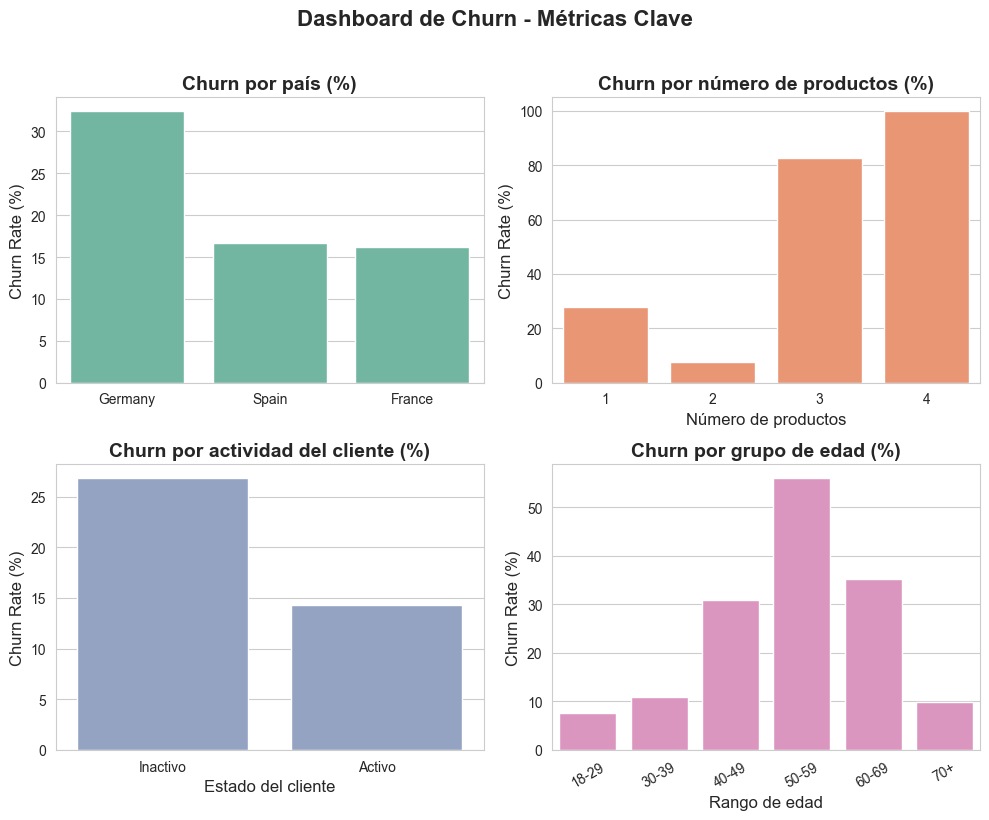

In [51]:
#Dashboard principal de métricas clave
palette_main = sns.color_palette("Set2")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Churn por país
sns.barplot(
    x='Geography', 
    y='ChurnRatePercent', 
    data=results['Churn_por_pais'], 
    color=palette_main[0], 
    ax=axes[0,0]
)
axes[0,0].set_title('Churn por país (%)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[0,0].set_xlabel('')

# Churn por número de productos
sns.barplot(
    x='NumOfProducts', 
    y='ChurnRatePercent', 
    data=results['Churn_por_num_productos'], 
    color=palette_main[1], 
    ax=axes[0,1]
)
axes[0,1].set_title('Churn por número de productos (%)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Churn Rate (%)', fontsize=12)
axes[0,1].set_xlabel('Número de productos', fontsize=12)

# Churn por actividad
activity_labels = {0: 'Inactivo', 1: 'Activo'}
results['Churn_por_actividad']['Activity_Label'] = results['Churn_por_actividad']['IsActiveMember'].map(activity_labels)
sns.barplot(
    x='Activity_Label', 
    y='ChurnRatePercent', 
    data=results['Churn_por_actividad'], 
    color=palette_main[2], 
    ax=axes[1,0]
)
axes[1,0].set_title('Churn por actividad del cliente (%)', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1,0].set_xlabel('Estado del cliente', fontsize=12)

# Churn por rango de edad
sns.barplot(
    x='Age_group', 
    y='ChurnRatePercent', 
    data=results['Churn_por_rango_edad'], 
    color=palette_main[3], 
    ax=axes[1,1]
)
axes[1,1].set_title('Churn por grupo de edad (%)', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1,1].set_xlabel('Rango de edad', fontsize=12)
axes[1,1].tick_params(axis='x', rotation=30)

plt.suptitle('Dashboard de Churn - Métricas Clave', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

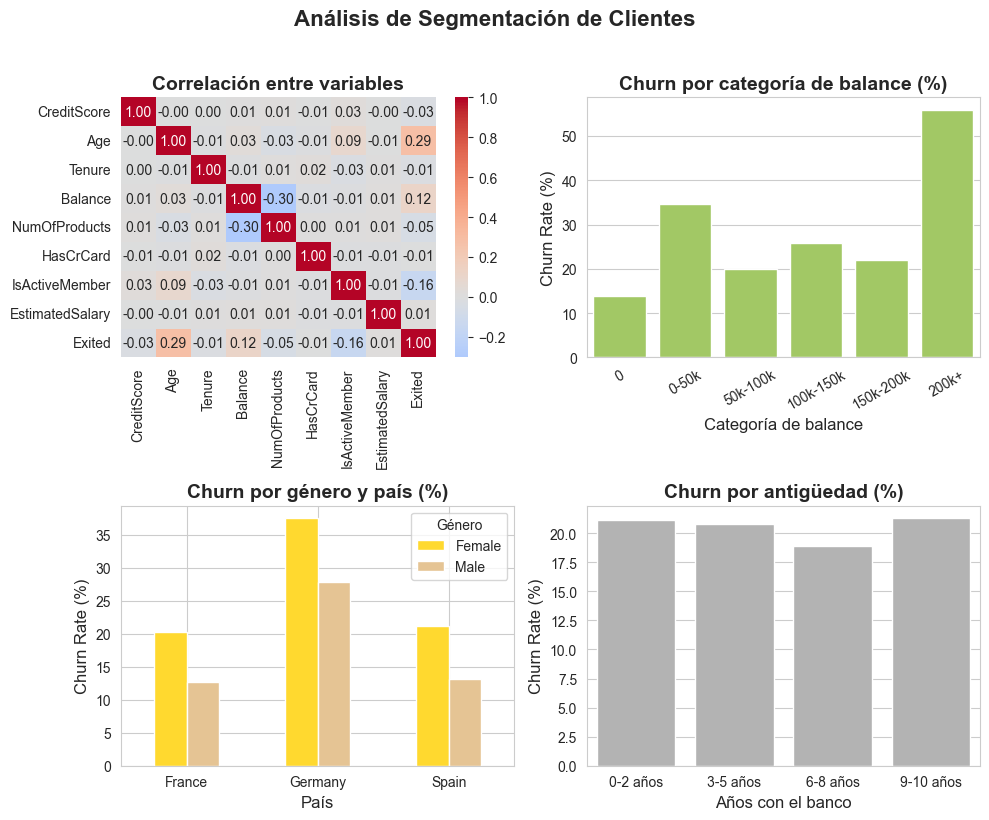

In [52]:
# Análisis de segmentación
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Heatmap de correlación con variables clave
correlation_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
correlation_matrix = df[correlation_vars].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Correlación entre variables', fontsize=14, fontweight='bold')

# Churn por categoría de balance
balance_churn = df.groupby('Balance_category', observed=True)['Exited'].agg(['mean', 'count']).reset_index()
balance_churn['ChurnRate'] = balance_churn['mean'] * 100
sns.barplot(x='Balance_category', y='ChurnRate', data=balance_churn, color=palette_main[4], ax=axes[0,1])
axes[0,1].set_title('Churn por categoría de balance (%)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Churn Rate (%)', fontsize=12)
axes[0,1].set_xlabel('Categoría de balance', fontsize=12)
axes[0,1].tick_params(axis='x', rotation=30)

# Churn por género y país
gender_country = df.groupby(['Geography', 'Gender'])['Exited'].mean().reset_index()
gender_country['ChurnRate'] = gender_country['Exited'] * 100
pivot_gc = gender_country.pivot(index='Geography', columns='Gender', values='ChurnRate')
pivot_gc.plot(kind='bar', ax=axes[1,0], color=[palette_main[5], palette_main[6]])
axes[1,0].set_title('Churn por género y país (%)', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1,0].set_xlabel('País', fontsize=12)
axes[1,0].legend(title='Género')
axes[1,0].tick_params(axis='x', rotation=0)

# Tenure vs Churn
tenure_bins = [0, 2, 5, 8, 10]
tenure_labels = ['0-2 años', '3-5 años', '6-8 años', '9-10 años']
df['Tenure_group'] = pd.cut(df['Tenure'], bins=tenure_bins, labels=tenure_labels, include_lowest=True)
tenure_churn = df.groupby('Tenure_group', observed=True)['Exited'].agg(['mean', 'count']).reset_index()
tenure_churn['ChurnRate'] = tenure_churn['mean'] * 100
sns.barplot(x='Tenure_group', y='ChurnRate', data=tenure_churn, color=palette_main[7], ax=axes[1,1])
axes[1,1].set_title('Churn por antigüedad (%)', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1,1].set_xlabel('Años con el banco', fontsize=12)

plt.suptitle('Análisis de Segmentación de Clientes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

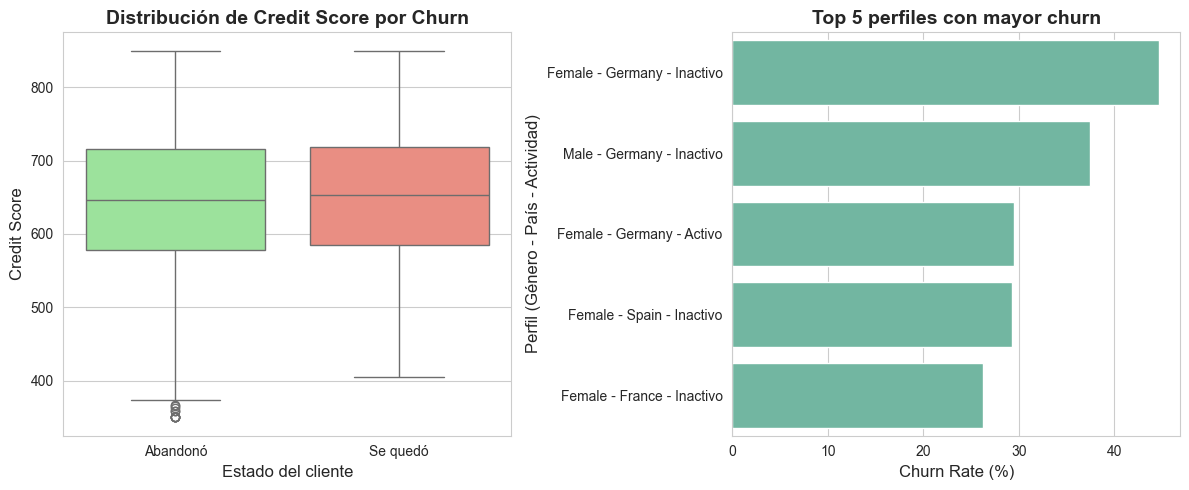

In [43]:
# Perfil de clientes de alto riesgo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribución de Credit Score por churn
sns.boxplot(x='Churn_Label', y='CreditScore', hue='Churn_Label', data=df, 
            palette=['lightgreen', 'salmon'], ax=axes[0], legend=False)
axes[0].set_title('Distribución de Credit Score por Churn', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Credit Score', fontsize=12)
axes[0].set_xlabel('Estado del cliente', fontsize=12)

# Top 5 combinaciones de características con mayor churn
profile_churn = df.groupby(['Gender', 'Geography', 'IsActiveMember'])['Exited'].agg(['mean', 'count']).reset_index()
profile_churn = profile_churn[profile_churn['count'] >= 50]  # Filtrar grupos pequeños
profile_churn['ChurnRate'] = profile_churn['mean'] * 100
profile_churn['Profile'] = profile_churn['Gender'] + ' - ' + profile_churn['Geography'] + ' - ' + profile_churn['IsActiveMember'].map({0: 'Inactivo', 1: 'Activo'})
top_profiles = profile_churn.nlargest(5, 'ChurnRate')

sns.barplot(y='Profile', x='ChurnRate', data=top_profiles, color=palette_main[0], ax=axes[1])
axes[1].set_title('Top 5 perfiles con mayor churn', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn Rate (%)', fontsize=12)
axes[1].set_ylabel('Perfil (Género - País - Actividad)', fontsize=12)

plt.tight_layout()
plt.show()

In [53]:
# Mini Conclusiones
print("\n=== RESUMEN DE INSIGHTS CLAVE ===")
print(f"Tasa de churn general: {df['Exited'].mean()*100:.2f}%")
print(f"País con mayor churn: {results['Churn_por_pais'].iloc[0]['Geography']} ({results['Churn_por_pais'].iloc[0]['ChurnRatePercent']}%)")
print(f"Clientes con 3+ productos tienen un churn del: {results['Churn_por_num_productos'][results['Churn_por_num_productos']['NumOfProducts'] >= 3]['ChurnRatePercent'].values[0]}%")
print(f"Clientes inactivos tienen {results['Churn_por_actividad'][results['Churn_por_actividad']['IsActiveMember'] == 0]['ChurnRatePercent'].values[0] - results['Churn_por_actividad'][results['Churn_por_actividad']['IsActiveMember'] == 1]['ChurnRatePercent'].values[0]:.1f}% más churn que los activos")

conn.close()


=== RESUMEN DE INSIGHTS CLAVE ===
Tasa de churn general: 20.37%
País con mayor churn: Germany (32.44%)
Clientes con 3+ productos tienen un churn del: 82.71%
Clientes inactivos tienen 12.6% más churn que los activos
